In [1]:
import numpy as np
import xarray as xr
import scipy.io as sio
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
rootdir = '/raid1/chen423/serdp/archive/GRL2020/'

plotdir = rootdir + 'plots/'

In [3]:
ARtag = 'p85'

In [4]:
ts_full = pd.date_range(start='2003-10-01', end='2015-09-30', freq='D')
ts_monthly = pd.period_range(start='2003-10', end='2015-09', freq='M')

In [5]:
# NARR in SERDP6km grids (from remapnn)
file_NARRraw = rootdir + 'data/NARR/SERDP6km/NARR_ARtag.Gershunov.200310-201512.AR%s.monsum.nc' % ARtag
ARcount_NARR = xr.open_dataset(file_NARRraw).AR_tag.values[0:144]

In [6]:
# WRF
file_NARR_WRF = rootdir + 'data/HIST/AR_tag/Gershunov/SERDP6km_adj/stats/WRF_ARtag_adj.HIST.Gershunov.200310-201512.AR%s.monsum.nc' % ARtag
ARcount_WRF = xr.open_dataset(file_NARR_WRF).AR_tag.values[0:144]

In [7]:
reffile = rootdir + 'data/common_ref/latlon.nc'
wrf_lats = xr.open_dataset(reffile).XLAT_M.values
wrf_lons = xr.open_dataset(reffile).XLONG_M.values

## plots

In [8]:
import cartopy
import cartopy.crs as ccrs

# for shapefile
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# NCL colormap
import matplotlib
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re


# ticks
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [9]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # convert rgb colors to arrays
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))
        
        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python
    
    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])
            
    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    
    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)
    
    if reverse_cmap==True:
        cmap_discrete_raw.reverse()
    
    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw
    
    if cont_opt==False:
        out_cmap = cmap_discrete
        
    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])
        
    return matplotlib.colors.ListedColormap(out_cmap)


def crt_cbar_labels(vmax, n_interval, mode='diff', decimal_flag=0, perc_flag=False, vmin=0):
    # crt_cbar_labels:  create the colorbar label lists
    #   mode:  choose between "diff" and "0ton". "diff" means setting the colorbar as -vmax to vmax, "0ton" 
    #          means setting the colorbar as 0 to vmax
    #   n_interval:  how many segments are there? See example below.
    #   decimal_flag:  control the text format. Default to 0.
    #
    # Example:
    #      > crt_cbar_labels(80, 4, mode='diff', decimal_flag=0)
    #      >  ['-80', '-40', '0', '40', '80']
    #      > crt_cbar_labels(80, 4, mode='0ton', decimal_flag=1)
    #      >  ['0.0', '20.0', '40.0', '60.0', '80.0']
    
    if perc_flag==True:
        format_string = '%%.%df%%%%' % (decimal_flag)
    else:
        format_string = '%%.%df' % (decimal_flag)
    #print(format_string)
    outdata = []
    
    if mode=='diff':
        n_interval = n_interval/2
        for i in np.arange(-1*n_interval, n_interval+0.000001, 1):
            outdata.append(format_string%(vmax*i/n_interval))
    if mode=='0ton':
        for i in np.arange(0, n_interval+0.000001, 1):
            outdata.append(format_string%(vmax*i/n_interval))
    if mode=='minmax':
        for i in np.arange(0, n_interval+0.000001, 1):
            outdata.append(format_string%(vmin + (vmax-vmin)*i/n_interval))
        
    return outdata

In [10]:
def visualize_wUS_map(axis, lons, lats, indata, cmap='bwr_r', label='', color=False,
                      location=[False,False,False,False], norm=False, vmin=0, vmax=1, title='',
                      xlim=[-127,-100], ylim=[26,55], map_bdy=False, wUS_bdy=False, wUS_range=4, **kwarg):
    if color!=False:
        axis.pcolormesh(lons, lats, indata, color=color, **kwarg)
    else:
        if norm==False:
            axis.pcolormesh(lons, lats, indata, cmap=cmap, vmin=vmin, vmax=vmax, zorder=2, **kwarg)
        else:
            axis.pcolormesh(lons, lats, indata, cmap=cmap, norm=norm, zorder=2, **kwarg)

    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    
    if map_bdy==False:
        # turn off the bounding box for cartopy
        axis.outline_patch.set_visible(False)

    #axis.add_feature(cartopy.feature.OCEAN, linewidth=0.5, facecolor='aliceblue', edgecolor='k', alpha=0.5, zorder=0)
    axis.add_feature(cartopy.feature.OCEAN, linewidth=0.5, facecolor='none', edgecolor='k', zorder=0)
    axis.add_feature(cartopy.feature.LAND, linewidth=0.5, facecolor='none', edgecolor='k', zorder=1)

    if wUS_bdy==True:
        shpfile = rootdir + 'data/common_ref/wUS_%dstates/US_states.shp' % (wUS_range)
        shape_feature = ShapelyFeature(Reader(shpfile).geometries(), ccrs.PlateCarree(), 
                                       facecolor='none', edgecolor='black', linewidth=0.5)
        axis.add_feature(shape_feature, zorder=4)

    countries = cartopy.feature.NaturalEarthFeature(category='cultural', scale='10m', edgecolor='grey', linewidth=0.5,\
                                                    facecolor='none', name='admin_1_states_provinces')
    axis.add_feature(countries, zorder=3)
    
    gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', alpha=1)
    gl.xlabels_top = location[0]
    gl.xlabels_bottom = location[1]
    gl.ylabels_left = location[2]
    gl.ylabels_right = location[3]
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,-59,10))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(0,81,10))
    
    axis.set_title(title, size=12)
    axis.text(-124, 34, label, ha='left', va='top', size=12)

In [11]:
def crt_refdata():    
    reffile = rootdir + 'data/common_ref/US_state.nc'
    wUS_mask_stack = xr.open_dataset(reffile).state_mask.values
    WRF_mask_wUS = wUS_mask_stack[0:3].sum(axis=0) + wUS_mask_stack[4]
    
    wUS_mask_by_region = wUS_mask_stack[0] + wUS_mask_stack[1] + 2*wUS_mask_stack[2] + 2*wUS_mask_stack[4]
    
    return 1-WRF_mask_wUS, wUS_mask_by_region

In [12]:
mask_wUS, msk_wUS_2region = crt_refdata()

## 2. my hovmoller

In [13]:
slat = 32
elat = 48
lat_int = 1

n_lat_band = np.arange(slat, elat+0.0001, lat_int).shape[0]
lat_band_mask = np.zeros((450,450))

for i in np.arange(slat, elat+0.0001, lat_int):
    lat_band_mask[(wrf_lats>i)*(wrf_lats<=(i+lat_int))*(mask_wUS==0)] = i

In [14]:
def compute_hovmollder_data(indata, slat=32, elat=48, int_lat=2):
    outdata = [indata[lat_band_mask==i].mean()/30/4 for i in np.arange(slat, elat+0.0001, int_lat)]
    return outdata

In [15]:
hov_NARR = np.zeros((n_lat_band, 144))
for i in np.arange(144):
    hov_NARR[:,i] = compute_hovmollder_data(ARcount_NARR[i], int_lat=lat_int)
    
hov_WRF = np.zeros((n_lat_band, 144))
for i in np.arange(144):
    hov_WRF[:,i] = compute_hovmollder_data(ARcount_WRF[i], int_lat=lat_int)

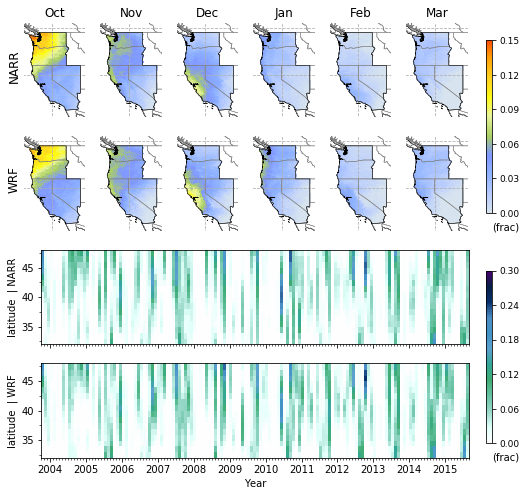

In [16]:
cmap_map = generate_NCL_cmap('perc2_9lev', cont_opt=True)
cmap_hov = generate_NCL_cmap('precip4_11lev', cont_opt=True)

mask_to_use = mask_wUS

if ARtag=='p85':
    vmax_map = 0.15
    vmax_hov = 0.3
elif ARtag=='abs':
    vmax_map = 0.2
    vmax_hov = 0.3


fig3, axes = plt.subplots(4,6, figsize=(8,8), subplot_kw={'projection':ccrs.PlateCarree()})

months = [10, 11, 12, 1, 2, 3]
month_strs = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']

for i in np.arange(6):
    valid_index = ts_monthly.month==months[i]
    plotdata = np.ma.masked_array(ARcount_NARR[valid_index].mean(axis=0)/30/4, mask=mask_to_use)
    visualize_wUS_map(axes[0][i], wrf_lons, wrf_lats, plotdata, title=month_strs[i],
                      cmap=cmap_map, vmin=0, vmax=vmax_map, xlim=[-126,-113], ylim=[31,51],
                      wUS_bdy=True, wUS_range=4)
    plotdata = np.ma.masked_array(ARcount_WRF[valid_index].mean(axis=0)/30/4, mask=mask_to_use)
    visualize_wUS_map(axes[1][i], wrf_lons, wrf_lats, plotdata, title='',
                      cmap=cmap_map, vmin=0, vmax=vmax_map, xlim=[-126,-113], ylim=[31,51],
                      wUS_bdy=True, wUS_range=4)
    

cbar_ax1 = fig3.add_axes([0.93, 0.55, 0.01, 0.3])
cb1 = matplotlib.colorbar.ColorbarBase(cbar_ax1, cmap=cmap_map,
                                       ticks=np.arange(0, 1.00001, 1/5), orientation='vertical')
cb1.set_ticklabels(crt_cbar_labels(vmax_map, 5, mode='0ton', decimal_flag=2))
cbar_ax1.tick_params(labelsize=9)
cbar_ax1.text(1, -0.1, '(frac)', size=10)

cbar_ax2 = fig3.add_axes([0.93, 0.15, 0.01, 0.3])
cb2 = matplotlib.colorbar.ColorbarBase(cbar_ax2, cmap=cmap_hov,
                                       ticks=np.arange(0, 1.00001, 1/5), orientation='vertical')
cb2.set_ticklabels(crt_cbar_labels(vmax_hov, 5, mode='0ton', decimal_flag=2))
cbar_ax2.tick_params(labelsize=9)
cbar_ax2.text(1, -0.1, '(frac)', size=10)

axes[0][0].text(-128, 42, 'NARR', ha='center', va='center', rotation=90, size=12)
axes[1][0].text(-128, 42, 'WRF', ha='center', va='center', rotation=90, size=12)

axis_add1 = plt.subplot2grid((4,24), (2,1), colspan=23, rowspan=1)
axis_add2 = plt.subplot2grid((4,24), (3,1), colspan=23, rowspan=1)
axis_add1.pcolormesh(np.arange(144), np.arange(slat, elat+0.000001, lat_int), hov_NARR, cmap=cmap_hov, vmin=0, vmax=vmax_hov)
axis_add2.pcolormesh(np.arange(144), np.arange(slat, elat+0.000001, lat_int), hov_WRF, cmap=cmap_hov, vmin=0, vmax=vmax_hov)

axis_add1.set_ylabel('latitude  | NARR')
axis_add2.set_ylabel('latitude  | WRF')
for axis in [axis_add1, axis_add2]:
    axis.set_xticks(np.arange(3, 144, 12))
    axis.set_xticklabels([])
    axis.xaxis.set_minor_locator(MultipleLocator(1))
    axis.set_yticks(np.arange(35, 46, 5))
    axis.yaxis.set_minor_locator(MultipleLocator(2.5))
    
axis_add2.set_xticklabels(np.arange(2004, 2016))
axis_add2.set_xlabel('Year')

#figname = plotdir + 'fig_S1.AR_eval.AR%s.png' % ARtag
#fig3.savefig(figname, dpi=600)

plt.show()
plt.close()
del(fig3)